In [1]:
import os
import re
import json
import csv
import rdkit
import matplotlib.pyplot as plt
import string
import unicodedata
import safe

# This is relative to the root directory of this repository
outdir = "out/libinvent"


# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

root = os.path.abspath(os.path.join(ipynb_path, '..'))
outpath = os.path.join(root, outdir)

os.makedirs(outpath, exist_ok=True)

C:\Users\ankit\mambaforge\envs\exp-re\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def dump_input_and_return_path(inputs):
    dump_path = os.path.join(outpath, 'libinvent_input.csv')

    with open(dump_path, 'w', newline='') as f:
        csvwriter = csv.writer(f)
        for row in inputs:
            csvwriter.writerow([row])
    return dump_path

In [3]:
input_path = dump_input_and_return_path(["[*:1]CO"])
# input_path = dump_input_and_return_path([
#     'O=S(=O)(NC1=CC(C2=C(C3=NC([*:1])=NC=C3)SC=N2)=CC=C1)C1=CC=CC=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC([*:2])=C3)SC=N2)=CC=C1)C1=CC=CC=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3[*:3])SC=N2)=CC=C1)C1=CC=CC=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3)SC([*:4])=N2)=CC=C1)C1=CC=CC=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3)SC=N2)=C([*:5])C=C1)C1=CC=CC=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3)SC=N2)=CC([*:6])=C1)C1=CC=CC=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3)SC=N2)=CC=C1[*:7])C1=CC=CC=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3)SC=N2)=CC=C1)C1=C([*:8])C=CC=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3)SC=N2)=CC=C1)C1=CC([*:9])=CC=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3)SC=N2)=CC=C1)C1=CC=C([*:10])C=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3)SC=N2)=CC=C1)C1=CC=CC([*:11])=C1',
#     'O=S(=O)(NC1=CC(C2=C(C3=NC=NC=C3)SC=N2)=CC=C1)C1=CC=CC=C1[*:12]',
#     'O=S(=O)(NC1=C([*:13])C(C2=C(C3=NC=NC=C3)SC=N2)=CC=C1)C1=CC=CC=C1',
# ])

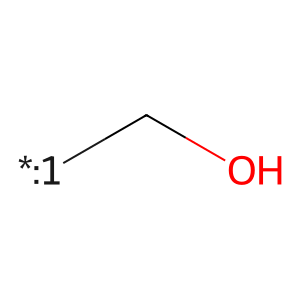

In [4]:

# Visualize input moelcules

with open(input_path) as fp:
    while True:
        mol = fp.readline()
        if mol == '':
            break
        m = rdkit.Chem.MolFromSmiles(mol)
        display(rdkit.Chem.Draw.MolToImage(m))


In [14]:
config = {
    "run_type": "sampling",
    "parameters": {
        "model_file": os.path.join(root, "priors/libinvent.prior"),
        "unique_molecules": True,
        "randomize_smiles": True,
        "smiles_file": input_path
    }
}

def dump_config_and_return_path(num_smiles=150):
    config["use_cuda"] = True
    config["parameters"]["num_smiles"] = num_smiles
    config["parameters"]["output_file"] = os.path.join(outpath, f"libinvent_{num_smiles}.csv")
    
    dump_path = os.path.join(outpath, f"libinvent_generate_config.json")
    
    
    with open(dump_path, 'w') as f:
        json.dump(config, f, indent=4)
        
    return dump_path

In [15]:
config_path = dump_config_and_return_path()

In [16]:
!reinvent {config_path} -f json

C:\Users\ankit\mambaforge\envs\exp-re\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
22:25:51 <INFO> Started REINVENT 4.1.8 (C) AstraZeneca 2017, 2023 on 2024-04-14
22:25:51 <INFO> Command line: C:\Users\ankit\mambaforge\envs\exp-re\Scripts\reinvent D:\projects\github\REINVENT4_NOTEBOOKS\out/libinvent\libinvent_generate_config.json -f json
22:25:51 <INFO> Environment loaded from dotenv file
22:25:51 <INFO> User ankit on host Ank
22:25:51 <INFO> Python version 3.10.13
22:25:51 <INFO> PyTorch version 2.2.1+cpu, git 6c8c5ad5eaf47a62fafbb4a2747198cbffbf1ff0
22:25:51 <INFO> PyTorch compiled with CUDA version None
22:25:51 <INFO> RDKit version 2023.09.5
22:25:51 <INFO> Platform Windows-10-10.0.26100-SP0
22:25:51 <INFO> Number of PyTorch CUDA devices 0
22:25:51 <INFO> Using CPU AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
22:25

In [76]:
# Visualize utils
def molecule_from_smiles_img(smi):
    return rdkit.Chem.Draw.MolToImage(rdkit.Chem.MolFromSmiles(smi))

def clean_filename(filename, replace="-"):
    whitelist = "-_.() %s%s" % (string.ascii_letters, string.digits)
    char_limit = 255
    # replace spaces
    for r in replace:
        filename = filename.replace(r, "_")

    # keep only valid ascii chars
    cleaned_filename = (
        unicodedata.normalize("NFKD", filename).encode("ASCII", "ignore").decode()
    )

    # keep only whitelisted chars
    cleaned_filename = "".join(c for c in cleaned_filename if c in whitelist)

    return cleaned_filename[:char_limit]

def plot_molecules(mol_str_1, mol_str_2):
    fig, axs = plt.subplots(
        1, 2, figsize=(10, 5)
    )  # Create a subplot with 1 row and 2 columns

    # Draw the input molecule
    axs[0].imshow(molecule_from_smiles_img(mol_str_1))
    axs[0].set_title("Input")
    axs[0].axis("off")  # Hide axes

    # Draw the output molecule
    axs[1].imshow(molecule_from_smiles_img(mol_str_2))
    axs[1].set_title("Output")
    axs[1].axis("off")  # Hide axes

    plt.savefig(
        os.path.join(outpath, 'images', clean_filename(mol_str_2)),
        dpi=500,
        bbox_inches="tight",
    )

    plt.show()


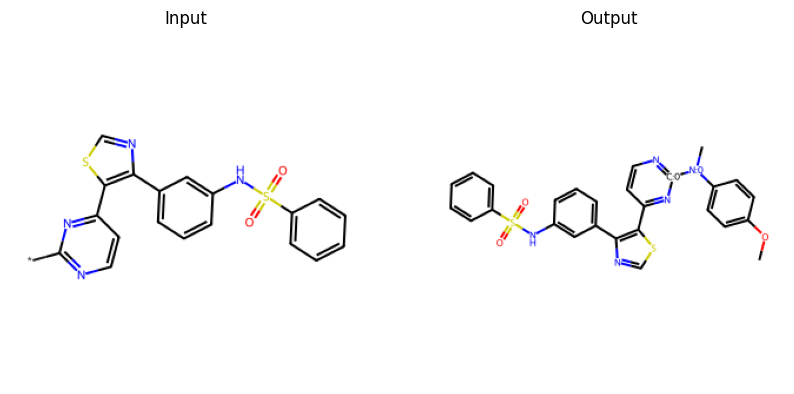

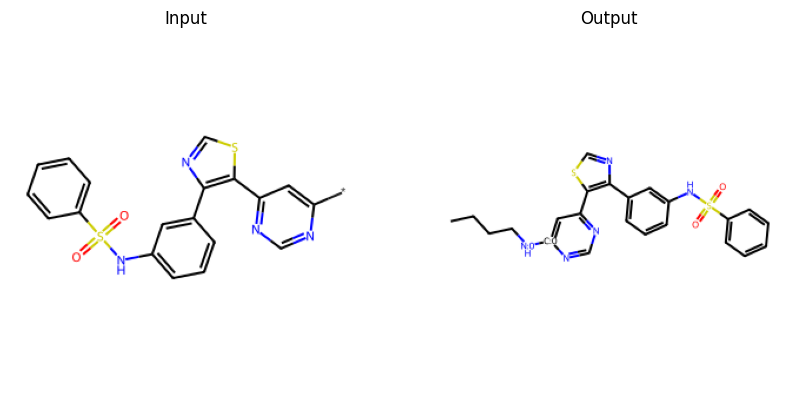

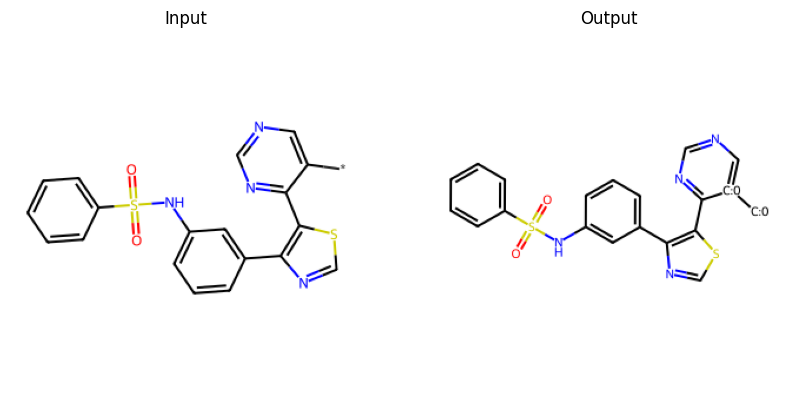

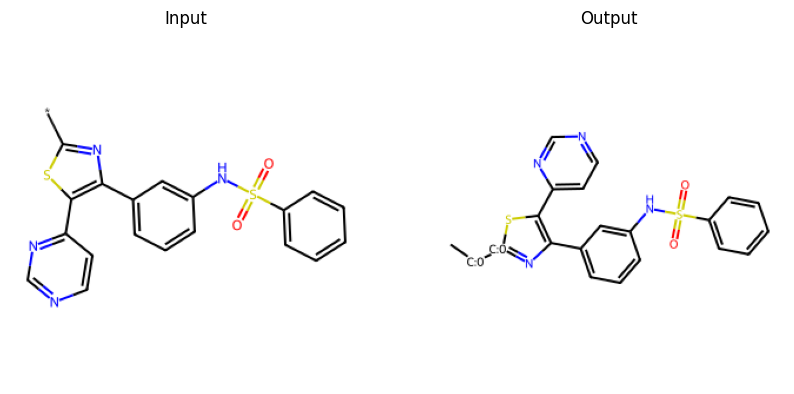

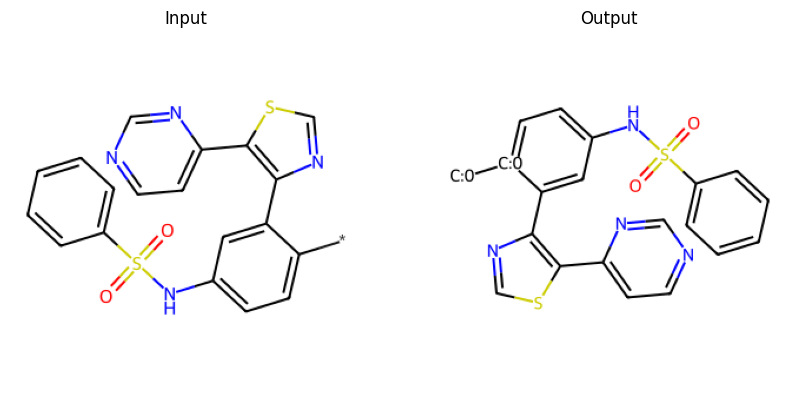

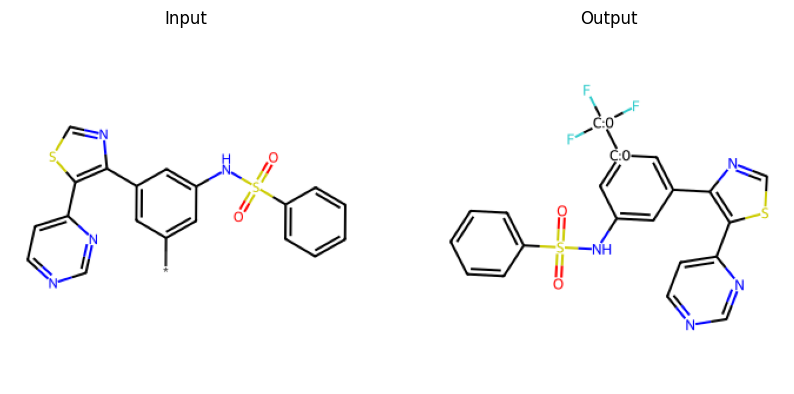

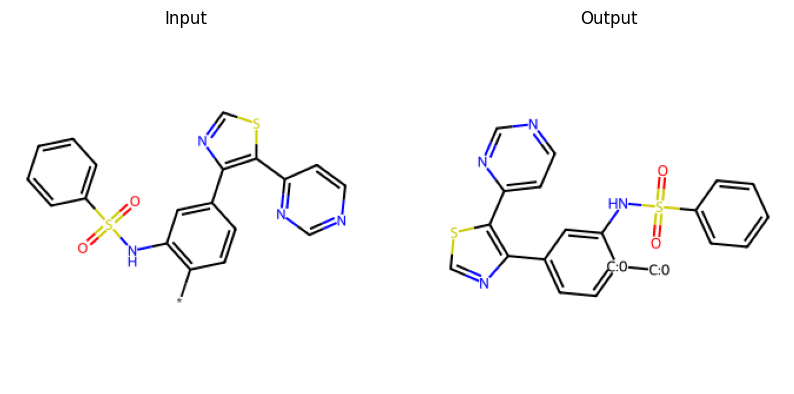

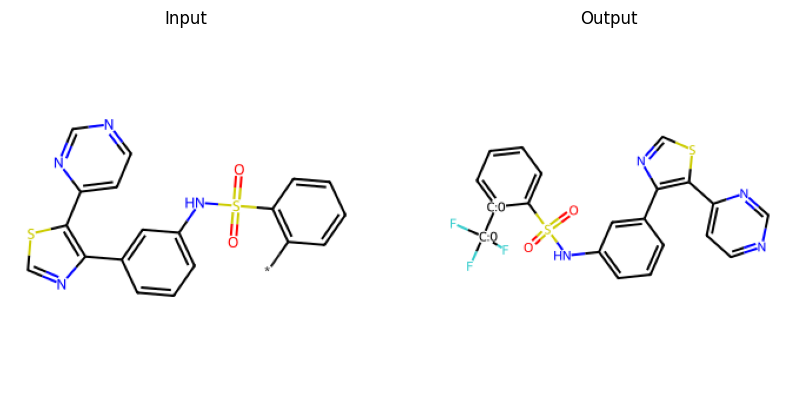

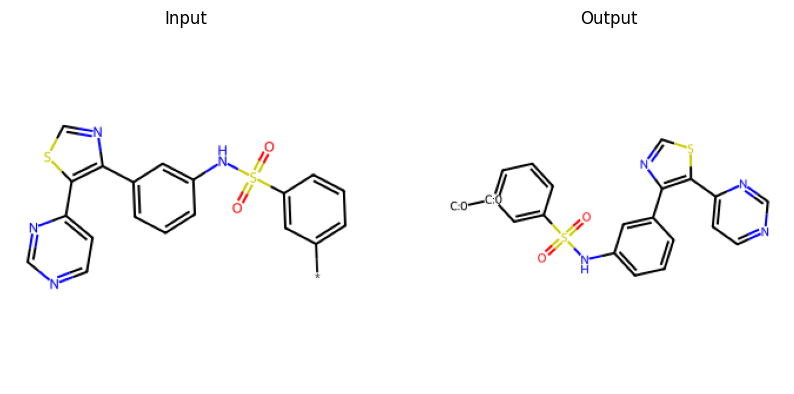

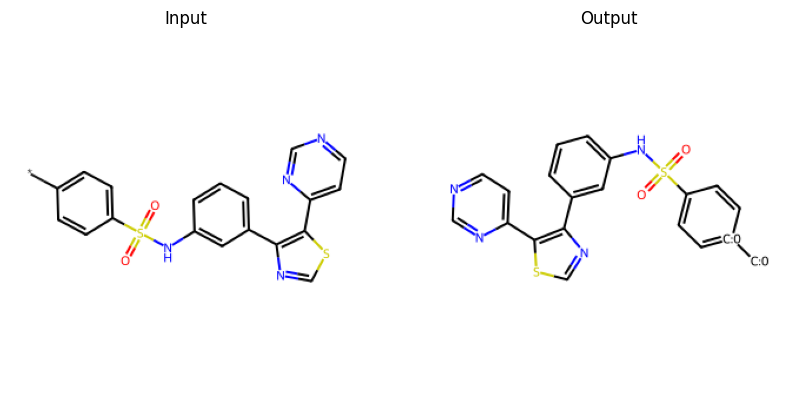

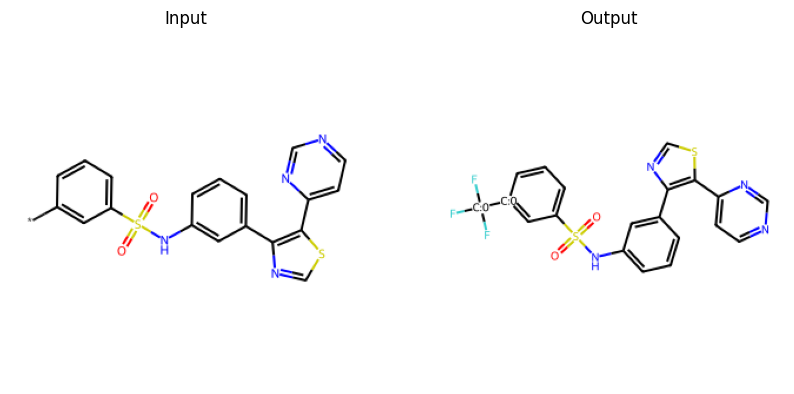

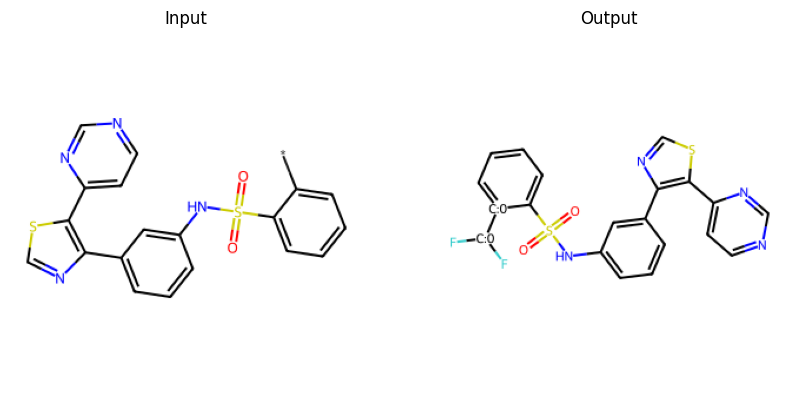

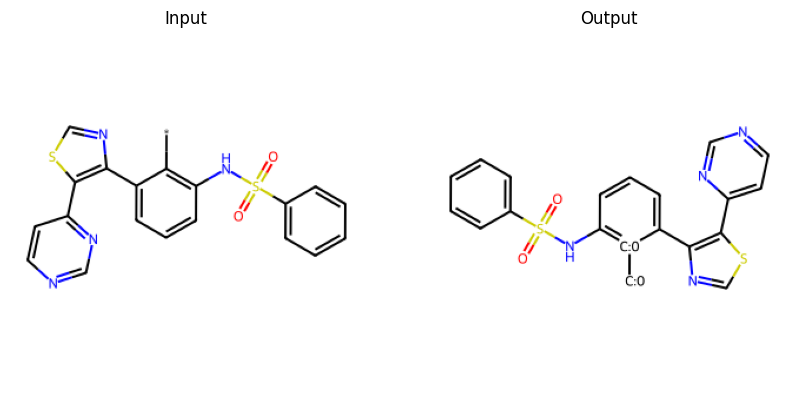

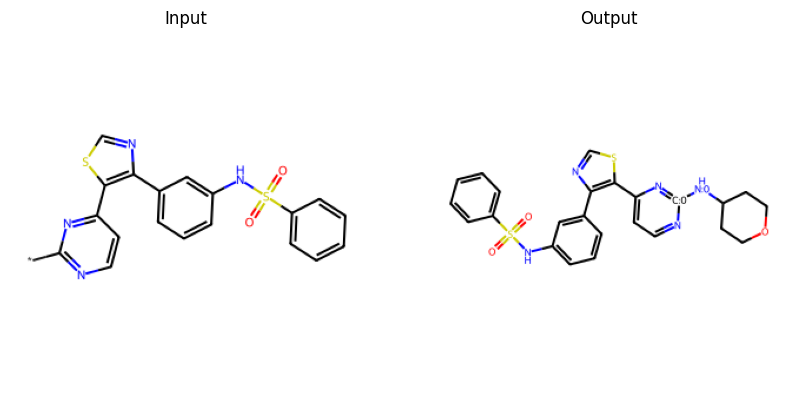

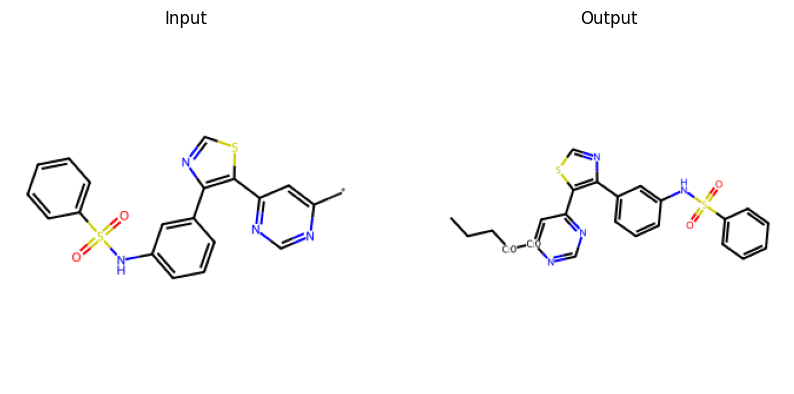

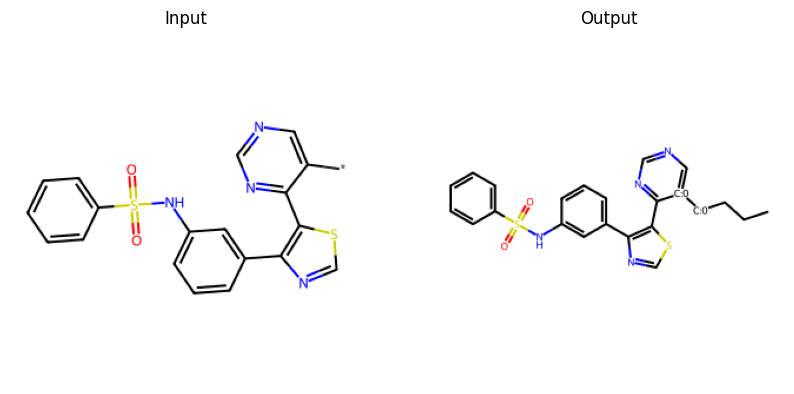

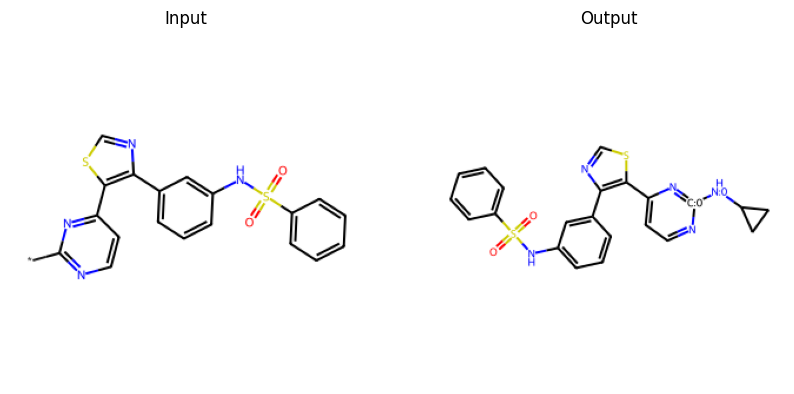

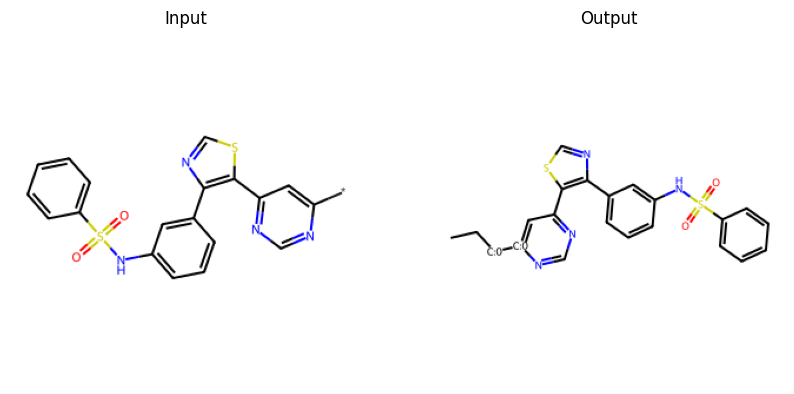

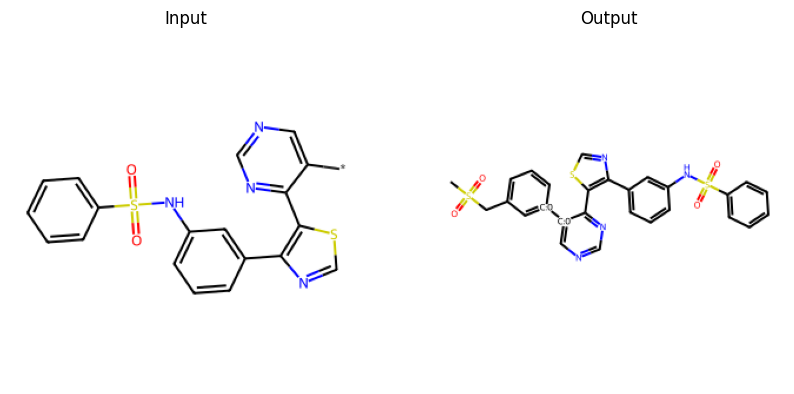

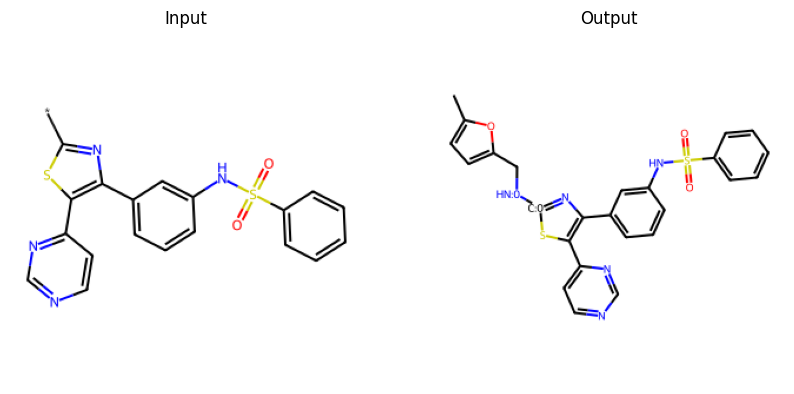

In [77]:
# Visualize molecules

output_csv_path = ""
with open(config_path) as fp:
    config = json.load(fp)
    output_csv_path = config['parameters']['output_file']


count = 0

def clean_smiles(smiles):
    return ''.join([c for c in smiles if c.isdigit() or c.isalpha() or c in ['(', ')', '[', ']', '=', '.', '@', '+', '-', '%', ' '] ])

with open(output_csv_path) as fp:
    csvreader = csv.reader(fp)
    next(csvreader)
    for row in csvreader:
        count += 1
        if count > 20:
            break
        plot_molecules(row[1], row[0])








## Explore Safe

In [34]:
def smile_to_safe(smile):
    return safe.encode(smile)

smile = "c1ccccc1"
safe_smile = smile_to_safe(smile)

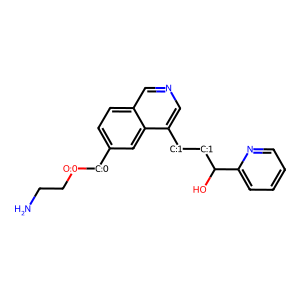

In [35]:
molecule_from_smiles_img(safe_smile)

# Make them Canonical form.
# Maybe we don't use safe.



In [11]:
safe_smile

from rdkit.Chem.Scaffolds import rdScaffoldNetwork

In [36]:
mol = rdkit.Chem.MolFromSmiles(safe_smile)
params = rdkit.Chem.Scaffolds.rdScaffoldNetwork.ScaffoldNetworkParams()
params.includeScaffoldsWithoutAttachments=False
net = rdkit.Chem.Scaffolds.rdScaffoldNetwork.CreateScaffoldNetwork([mol], params)
nodemols = [rdkit.Chem.MolFromSmiles(x) for x in net.nodes]

[20:47:42] Running LargestFragmentChooser


In [50]:
print(rdkit.Chem.MolToSmiles(nodemols[1]))
print(rdkit.Chem.MolToSmiles(nodemols[2]))


for node in nodemols:
    print(rdkit.Chem.MolToSmiles(node))


c1ccc(C[CH2:1][CH2:1]c2cncc3ccccc23)nc1
*(*1:*:*:*:*:*:1)[*:1][*:1]*1:*:*:*:*2:*:*:*:*:*:1:2
NCC[O:0][CH2:0]c1ccc2cncc([CH2:1][CH2:1]C(O)c3ccccn3)c2c1
c1ccc(C[CH2:1][CH2:1]c2cncc3ccccc23)nc1
*(*1:*:*:*:*:*:1)[*:1][*:1]*1:*:*:*:*2:*:*:*:*:*:1:2
*c1cncc2ccccc12
**1:*:*:*:*2:*:*:*:*:*:1:2
*c1ccccn1
**1:*:*:*:*:*:1


In [14]:
print(rdkit.__version__)

2023.09.5


In [30]:
from rdkit.Chem.Scaffolds import rdScaffoldNetwork

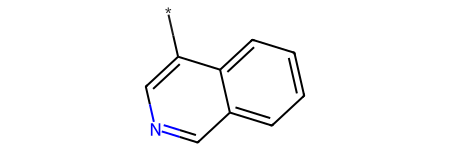

In [60]:
nodemols[3]

In [85]:
config_path

'D:\\projects\\github\\REINVENT4_NOTEBOOKS\\out/libinvent\\libinvent_generate_config.json'